In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyvista as pv
import SimpleITK as sitk
from stl import mesh
# import stltovoxel
from scipy.ndimage import zoom
import skimage.morphology as morph
from MedtoolFunctions import medtool_functions as mf

In [2]:
# Functions
def load_itk(filename):

    # Reads the image using SimpleITK
    itkimage = sitk.ReadImage(filename)

    # Convert the image to a  numpy array first and then shuffle the dimensions to get axis in the order z,y,x
    ct_scan = sitk.GetArrayFromImage(itkimage)
    ct_scan = np.transpose(ct_scan, (2, 1, 0))

    # Read the origin of the ct_scan, will be used to convert the coordinates from world to voxel and vice versa.
    origin = np.array(list(reversed(itkimage.GetOrigin())))

    # Read the spacing along each dimension
    spacing = np.array(list(reversed(itkimage.GetSpacing())))

    ct_trans = np.transpose(ct_scan, (1, 0, 2))
    ct_trans = ct_trans.astype(np.short)

    return ct_scan, origin, spacing

In [3]:
# Load the bone file for implantation

file = 'S131318_L4_left_screw_image.mhd'
path_bone = '/home/biomech/Documents/01_Icotec/01_Experiments/02_Scans/S131318_L4_left/04_Registered/'

file = path_bone + file
# load bone sample
data = load_itk(file)
data_img = data[0]
data_img.shape

(438, 644, 1137)

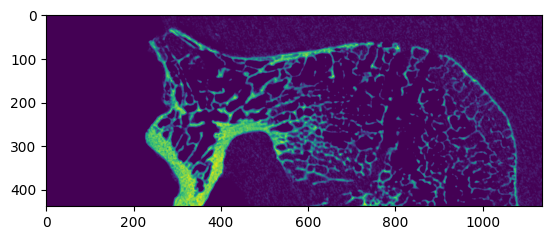

In [4]:
plt.imshow(data_img[:, int(data_img.shape[1]/2), :])

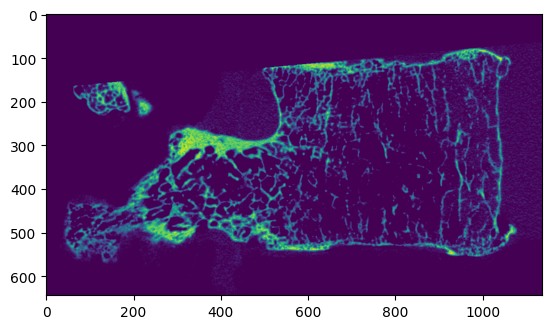

In [5]:
plt.imshow(data_img[int(data_img.shape[0]/2), :, :])

### Create mask for virtual implantation / insertion


In [6]:
# Load implant
path_implant = '/home/biomech/Documents/01_Icotec/02_FEA/01_MainStudy/S131318_L4_left/94_OSTP/'
#path_implant = '/home/biomech/Documents/01_Icotec/02_FEA/01_MainStudy/S131318_L4_left/81_L50_S50_D45_expl/'
#implant = 'S131318_L4_left_screw.mhd'
implant = '94_OSTP_mask.mhd'
#screw ='NA'
reso = 0.0606995
imp_data = load_itk(path_implant + implant)
imp_img = imp_data[0]
imp_img = np.flip(np.swapaxes(imp_img, 0, 2), 1)
print(imp_img.shape)
sitk.WriteImage(sitk.GetImageFromArray(imp_img), '/home/biomech/Downloads/FE_test/screw_test.mhd')

(132, 132, 824)


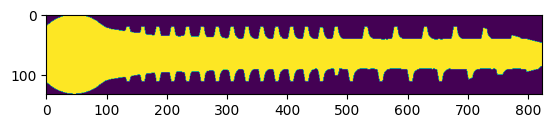

In [7]:
# Cut the upper part according to the offset
#path_simInfo = 'C:/Users/kirta/OneDrive - Universitaet Bern/01_MBArtorg/2021_Projects/2021_Schroedinger/04_SampleInfos/05_IMG_cropped_orientation/'
#file_rot = path_simInfo + sample + '_PILOT_CUTsimInfo.txt'
#df = pd.read_csv(file_rot)
#h = df.startPoint
#h = int(np.round(h * 0.0245/0.072, 0))

#L_tot = int(round(12.50 / 0.072, 0))
#start = int(L_tot + h)
#imp_img = imp_img[:,:, :start]

#imp_img = np.swapaxes(imp_img, 2, 0)

plt.imshow(imp_img[:, int(imp_img.shape[1]/2), :])


In [8]:
#L_tot * 0.072

In [9]:
#imp_img.shape, L_tot

In [10]:
# Enlargement of the implant - so there will be a small gap between implant and bone for the start of the simulation

# defines the size of the gap
blow = 2

add_l = np.zeros([imp_img.shape[0], imp_img.shape[1], blow])
mask = np.concatenate([add_l, imp_img, add_l], 2)

add_x = np.zeros([blow, mask.shape[1], mask.shape[2]])
mask = np.concatenate([add_x, mask, add_x], 0)

add_y = np.zeros([mask.shape[0], blow, mask.shape[2]])
mask = np.concatenate([add_y, mask, add_y], 1)#[blow:-blow, blow:-blow, blow:-blow]

footprint = morph.ball(blow)
mask_zoom = morph.dilation(mask, footprint)#[blow:-blow, blow:-blow, blow:-blow]

diff_mask = mask_zoom - mask
#mask_zoom = mask_zoom[blow:-blow, blow:-blow, blow:-blow]

print(imp_img.shape, mask_zoom.shape, mask.shape)

(132, 132, 824) (136, 136, 828) (136, 136, 828)


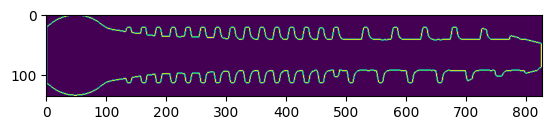

In [11]:
plt.imshow(diff_mask[:, int(diff_mask.shape[1]/2), :])

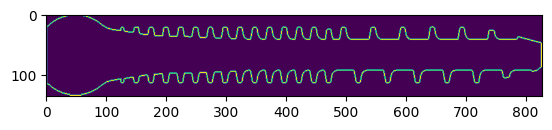

In [12]:
plt.imshow(diff_mask[int(diff_mask.shape[0]/2), : ,  :])

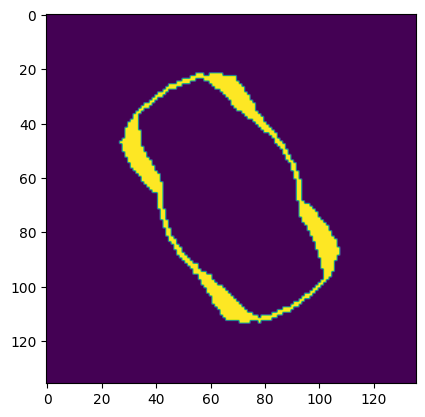

In [13]:
plt.imshow(diff_mask[ : , :, int(diff_mask.shape[2]/2)])

In [14]:
# Match the mask to the same size as the bone
orig_vox = [np.rint(-data[1]/data[2]).astype(int)[2],
            np.rint(-data[1]/data[2]).astype(int)[1],
            np.rint(-data[1]/data[2]).astype(int)[0]]
print(orig_vox)
print(mask_zoom.shape)
print(data_img.shape)

[232, 385, 796]
(136, 136, 828)
(438, 644, 1137)


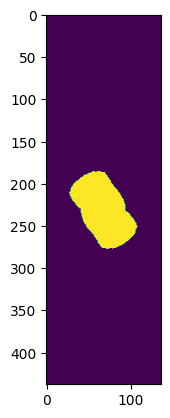

In [15]:

#add1 = np.zeros([int((data_img.shape[0] - mask_zoom.shape[0]) / 2), mask_zoom.shape[1], mask_zoom.shape[2]])
#add2 = np.zeros([int((data_img.shape[0] - mask_zoom.shape[0]) / 2), mask_zoom.shape[1], mask_zoom.shape[2]])
add1 = np.zeros([orig_vox[0] - int(mask_zoom.shape[0]/2), mask_zoom.shape[1], mask_zoom.shape[2]])
add2 = np.zeros([data_img.shape[0] - orig_vox[0] - int(mask_zoom.shape[0]/2), mask_zoom.shape[1], mask_zoom.shape[2]])
mask_zoom2 = np.concatenate([add1, mask_zoom, add2], 0)

plt.imshow(mask_zoom2[:, :, int(mask_zoom2.shape[2]/2)])


In [16]:
mask_zoom.shape  #, add1.shape, add2.shape

(136, 136, 828)

828
796


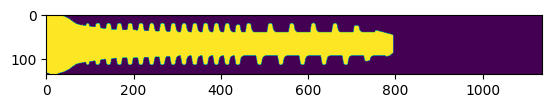

In [17]:

#add5 = np.zeros([mask_zoom.shape[0], mask_zoom.shape[1], int((data_img.shape[2] - mask_zoom.shape[2]) / 2)])

print(mask_zoom2.shape[2])
print(orig_vox[2])
if mask_zoom2.shape[2] > orig_vox[2]:
    mask_zoom22 = mask_zoom2[:, :, mask_zoom2.shape[2] - orig_vox[2]:]
add5 = np.zeros([mask_zoom22.shape[0], mask_zoom22.shape[1], orig_vox[2] - mask_zoom22.shape[2]])
#add6 = np.zeros([mask_zoom.shape[0], mask_zoom.shape[1], int((data_img.shape[2] - mask_zoom.shape[2]) / 2)])
add6 = np.zeros([mask_zoom22.shape[0], mask_zoom22.shape[1], data_img.shape[2] - orig_vox[2]])
mask_zoom3 = np.concatenate([add5, mask_zoom22, add6], 2)

#if mask_zoom.shape[2] < data_img.shape[2]:
#    diff = data_img.shape[2] - mask_zoom.shape[2]
#    add6_ = np.zeros([mask_zoom.shape[0], mask_zoom.shape[1], int(diff)])
#    mask_zoom = np.concatenate([mask_zoom, add6_], 2)

plt.imshow(mask_zoom3[orig_vox[0], :, :])

In [18]:
print(mask_zoom3.shape)
print(orig_vox)
#, add5.shape, add6.shape

(438, 136, 1137)
[232, 385, 796]


385
68.0
644


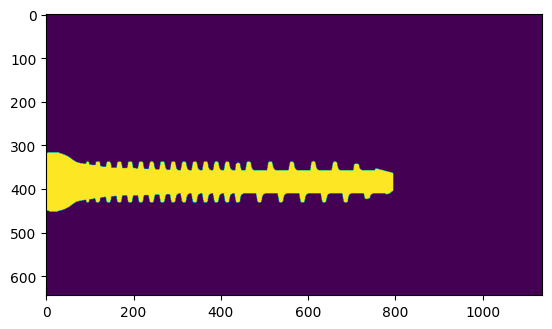

In [19]:
# Add material at the bottem
#add4 = np.zeros([mask_zoom.shape[0], int(data_img.shape[1] - mask_zoom.shape[1]), mask_zoom.shape[2]])
print(orig_vox[1])
print(mask_zoom3.shape[1]/2)
print(data_img.shape[1])
add3 = np.zeros([mask_zoom3.shape[0], orig_vox[1] - int(mask_zoom3.shape[1]/2), mask_zoom3.shape[2]])
add4 = np.zeros([mask_zoom3.shape[0], data_img.shape[1] - orig_vox[1] - int(mask_zoom3.shape[1]/2), mask_zoom3.shape[2]])
mask_zoom4 = np.concatenate([add3, mask_zoom3, add4], 1)

plt.imshow(mask_zoom4[orig_vox[0], :, :])

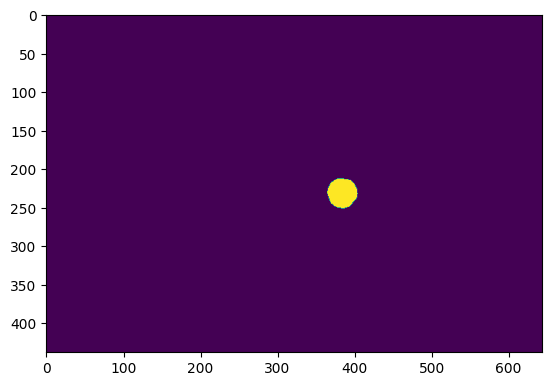

In [20]:
plt.imshow(mask_zoom4[:, :, orig_vox[2]-1])

In [21]:
mask_zoom4.shape

(438, 644, 1137)

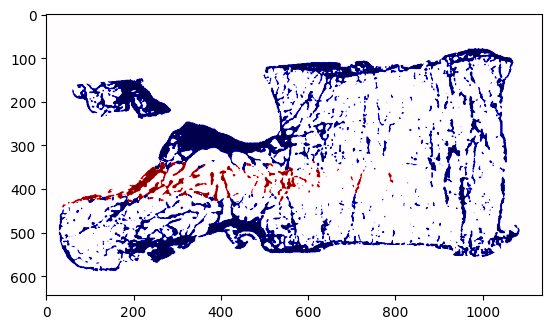

In [22]:
# Combine screw mask with bone
mask_zoom4_ = np.abs(mask_zoom4-1)
data_bvtv = np.array((data_img > 320).astype(int))
vir_img = np.array(mask_zoom4_ * data_img)
vir_bvtv = np.array((vir_img > 320).astype(int))
plt.imshow(vir_bvtv[orig_vox[0], :, :]*-2+data_bvtv[orig_vox[0], :, :], cmap='seismic')

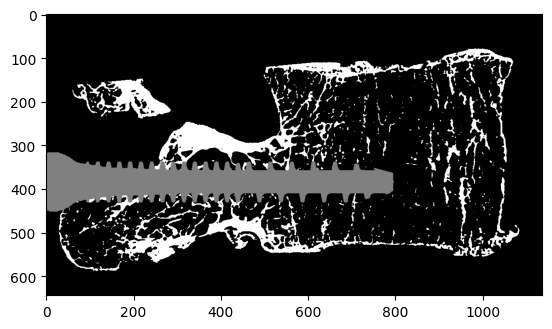

In [23]:
plt.imshow(vir_bvtv[orig_vox[0], :, :]*2 + mask_zoom4[orig_vox[0], :, :], cmap='gray')

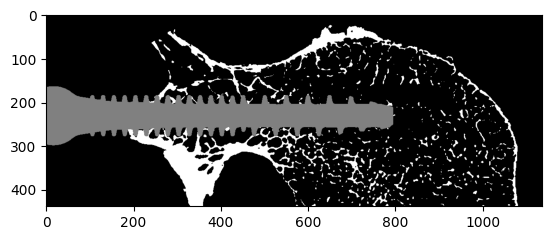

In [24]:
plt.imshow(vir_bvtv[:, orig_vox[1], :]*2 + mask_zoom4[:, orig_vox[1], :], cmap='gray')

In [25]:
# # Teil 1: Neu Ausrichtung des Knochens, damit es mit der Ausrichtung der Schraube übereinstimmt.
# vir_img = vir_img.T
# plt.imshow(vir_img[int(vir_img.shape[0]/2), :, :])

In [26]:
# # Teil 2: Neu Ausrichtung des Knochens, damit es mit der Ausrichtung der Schraube übereinstimmt.
#
# vir_img = np.swapaxes(vir_img, 2, 1)
#
# plt.imshow(vir_img[int(vir_img.shape[0]/2), :, :])

In [27]:
vir_img.shape

(438, 644, 1137)

In [28]:
# Create .mhd of mesh image

origin = [0, 0, 0]
spacing = np.array([1, 1, 1]) * reso
cylinder_trans = vir_img.astype(np.short)
itkimage = sitk.GetImageFromArray(np.transpose(cylinder_trans, [2, 1, 0]), isVector=None)
itkimage.SetSpacing(spacing)
itkimage.SetOrigin(origin)

mask_trans = mask_zoom4.astype(np.short)
itkmask = sitk.GetImageFromArray(np.transpose(mask_trans ,[2, 1, 0]), isVector=None)
itkmask.SetSpacing(spacing)
itkmask.SetOrigin(origin)

path_to_local_folder = '/home/biomech/Downloads/FE_test/'
reso_ = '0' + str(reso).split('.')[-1]
sitk.WriteImage(itkimage, path_to_local_folder + 'Mesh_' + 'test' + '_' + reso_ + '_test00.mhd')
sitk.WriteImage(itkmask, path_to_local_folder + 'Implant_mask_' + reso_ + '.mhd')

In [29]:
# Creat abaqus mesh

def mesh(img, path, storage, name, template):
    img = path + img

    img, origin, spacing = load_itk(img)

    inpName = storage + name

    mf.writeAbaqusGeneral(inpName, img, spacing, templateFile=template, smooth=None)

sample = 'test'
screw = 'ico'

img = 'Mesh_' + sample + '_' + reso_ + '_test00.mhd'
path = path_to_local_folder
# template = 'C:/Users/kirta/OneDrive - Universitaet Bern/01_MBArtorg/2021_Projects/2021_Schroedinger/' \
#            '03_Simulations/01_Meshes/mesh_temp_home.inp'
template = path + 'mesh_temp.inp'
mesh(img, path, path, 'Mesh_' + sample + '_' + reso_ + screw + 'test0.inp', template)

 ... setup ABAQUS *.inp file from template
     -> recast model from 'h' to 'i'
     -> setup Element Data  : |==========|
     -> setup Node Data     : Done
 ... write ABAQUS *.inp file from template
     -> process Node IDs    : |==========|
     -> write Nodes         :   25070665 
     -> process Elements    : |=|
     -> write Elements      :    4022811             
     -> write BCs Node Sets     
     -> Write Property      : /home/biomech/Downloads/FE_test/vumat.inp 
     -> Write finished in   :      283.1 sec  
